<a href="https://colab.research.google.com/github/pachterlab/LSCHWCP_2023/blob/main/Notebooks/Supp_Fig_10/Supp_Fig_10e/1_cluster_palmdb_seqs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# (Re)clustering the PalmDB sequences using MMseqs2
https://github.com/soedinglab/mmseqs2/wiki#usage-of-mmseqs2-modules  
https://github.com/soedinglab/mmseqs2/wiki#clustering-databases-using-mmseqs-cluster-or-mmseqs-linclust

The clustering will be performed on the sequences reverse translated to comma-free code as this is the same space we will perform the alignment in.

# Reverse translate PalmDB amino acid sequences into comma-free code (cfc)
Download the original PalmDB file containing amino acid RdRP sequences as provided by Edgar et al.
The file was originally downloaded from here: https://github.com/rcedgar/palmdb/blob/main/2021-03-14/uniques.fa.gz

In [ ]:
!wget https://github.com/pachterlab/LSCHWCP_2023/blob/main/Notebooks/create_optimized_palmdb/uniques.fa
palmdb = "uniques.fa"

Reverse translate the amino acid sequences to comma-free code:

In [ ]:
# amino acids to comma-free code dictionary
cfcode = {
    "F": "ACC",
    "L": "ACA",
    "I": "ATA",
    "M": "ATC",
    "V": "ATT",
    "S": "CTA",
    "P": "CTC",
    "T": "CTT",
    "A": "AGA",
    "Y": "AGC",
    "H": "AGT",
    "Q": "AGG",
    "N": "CGA",
    "K": "CGC",
    "D": "CGT",
    "E": "CGG",
    "C": "TGA",
    "W": "TGC",
    "R": "TGT",
    "G": "TGG",
    "X": "NNN",  # Amino acid not known
    "B": "CGT",  # Represents either N or D - will translate as D here (N is only off by one base)
    "J": "ACA",  # Represents either L or I - will translate as L here (I is only off by one base)
    "Z": "CGG"   # Represents either E or Q - will translate as E here (Q is only off by one base)
}

In [ ]:
palmdb_cfc = "uniques_cfc.fa"
with open(palmdb_cfc, "w") as new_code_fasta:
    for record in SeqIO.parse(palmdb, "fasta"):
        # Translate AA sequence to comma-free
        cfc_seq_temp = []
        for aa in record.seq:
            # Capitalize amino acid
            aa = aa.capitalize()

            # Rev translate to comme-free code
            cfc_seq_temp.append(cfcode[aa])

        new_code_fasta.write(">" + record.id + "\n")
        new_code_fasta.write("".join(cfc_seq_temp) + "\n")

# Install MMseqs2

In [ ]:
!git clone https://github.com/soedinglab/MMseqs2.git
!cd MMseqs2 && mkdir build && cd build && cmake -DCMAKE_BUILD_TYPE=RELEASE -DCMAKE_INSTALL_PREFIX=. .. && make

In [ ]:
mmseqs = "MMseqs2/bin/mmseqs"

# Cluster PalmDB sequences with MMseqs2

In [ ]:
# Define all output files
palmdb_DB = "palmdb_DB"
palmdb_DB_clu = "palmdb_DB_clu"
palmdb_DB_clu_rep = "palmdb_DB_clu_rep"
palmdb_DB_clu_rep_fasta = "palmdb_DB_clu_rep.fasta"
tmp_folder = "mmseqs_tmp"

### 1. Convert FASTA to MMseqs2 database (DB) format:

In [ ]:
!$mmseqs createdb $palmdb_cfc $palmdb_DB

### 2. Cluster amino-acid sequences using Mode 1
Also see: https://github.com/soedinglab/mmseqs2/wiki#how-to-set-the-right-alignment-coverage-to-cluster
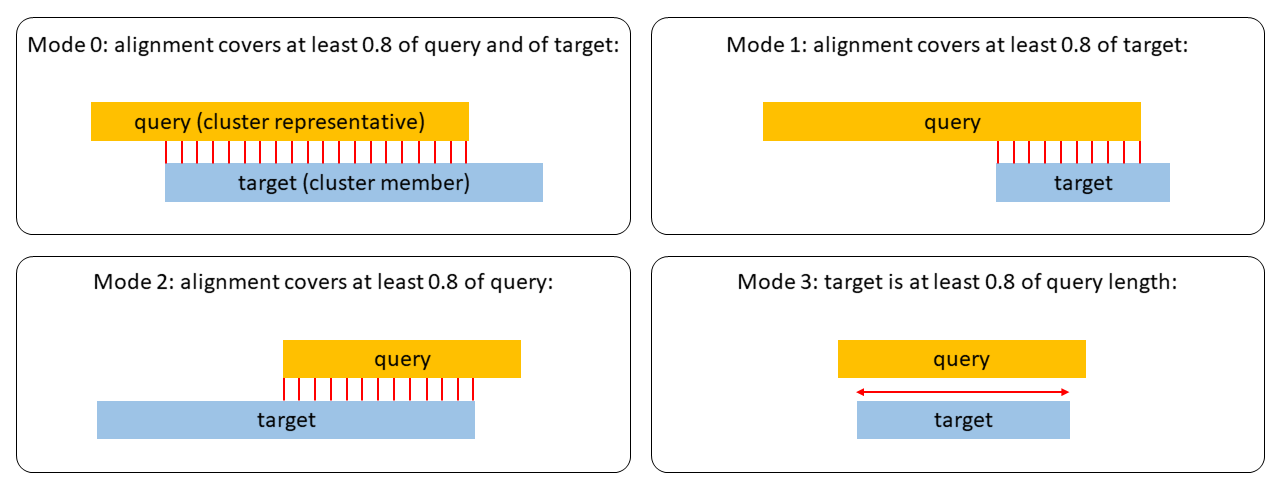

In [ ]:
threads = 2

In [ ]:
!$mmseqs cluster \
    -c 0.999 \
    --cov-mode 1 \
    --threads $threads \
     $palmdb_DB \
     $palmdb_DB_clu \
     $tmp_folder

In [ ]:
!$mmseqs createtsv \
    --threads $threads \
    $palmdb_DB \
    $palmdb_DB \
    $palmdb_DB_clu \
    palmdb_DB_clu.tsv

# Extract representative sequences

In [ ]:
!$mmseqs createsubdb \
    $palmdb_DB_clu \
    $palmdb_DB \
    $palmdb_DB_clu_rep

!$mmseqs convert2fasta \
    $palmdb_DB_clu_rep \
    $palmdb_DB_clu_rep_fasta